<h2>Import necessary packages</h2> 

In [34]:
# importing libraries
import pandas as pd
import numpy as np
# classical Time Series Tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# Utils
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import datetime
import warnings
warnings.filterwarnings('ignore')

<h2>Load, explore and prepare data</h2>


In [4]:
data_path = './data/btc-usd.csv'
def read_data(data_path):
    cols = ['Date', 'Close']
    df = pd.read_csv(data_path, parse_dates=['Date'])#, usecols=cols)
    df.Date = df.Date.apply(lambda x: x.date())
    df = df.set_index('Date')
    df = df.asfreq(freq='D')
    return df

df = read_data(data_path)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Once the data is set as frequential, it is a good practice to check for missing values. Fortunately there's no missing value in our data, as we can see below.

In [6]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df[df.High == df.High.max()][['High']]

,High
Date,
2021-11-10,68789.625


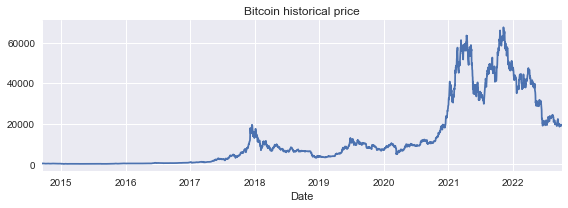

In [8]:
df = df[['Close']]
fig, ax = plt.subplots(figsize=(8,3))
df.plot(ax=ax, legend=False)
ax.set_title('Bitcoin historical price')
plt.tight_layout()
plt.show()


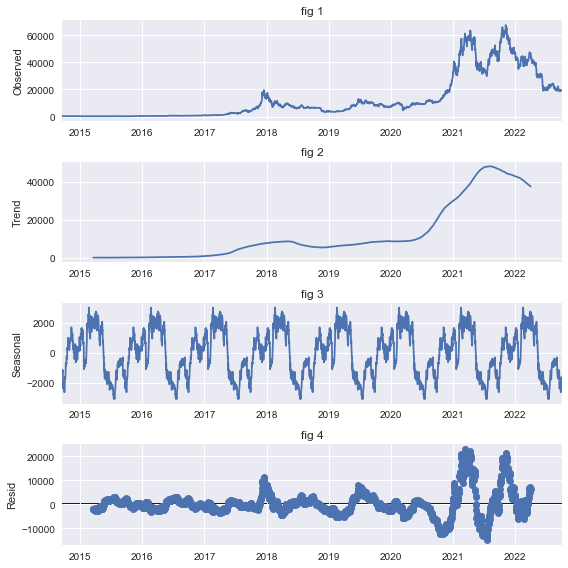

In [9]:
seasonal = seasonal_decompose(df, period=365)
g = seasonal.plot()
g.axes[0].set_ylabel('Observed')
g.set_figheight(8)
i = 1
for ax in g.axes:
    ax.set_title(f'fig {i}')
    i +=1
plt.tight_layout()
plt.show()

In [10]:
ad_fuller_result = adfuller(df.Close.values)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.674600921020317
p-value: 0.44424405673490297


In [11]:
n = 0
p_value = 10

while p_value >= 0.05:
    eps_diff = np.diff(df.Close.values, n=n)
    ad_fuller_result = adfuller(eps_diff)
    adf = ad_fuller_result[0]
    p_value = ad_fuller_result[1]
    print(f'n: {n}')
    print(f'ADF Statistic: {adf}')
    print(f'p-value: {p_value}\n')
    n+=1

n: 0
ADF Statistic: -1.674600921020317
p-value: 0.44424405673490297

n: 1
ADF Statistic: -9.009741276203606
p-value: 6.171914887313778e-15



In [12]:
# splitting the data into train and test sets
train = df.iloc[:-30]
test = df.iloc[-30:]

In [ ]:
def search_best_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int):
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df.head(3)

In [ ]:
ps = range(0, 7)
qs = range(0, 7)
d = 1
order_list = list(product(ps, qs))

result_df = search_best_ARIMA(train.Close, order_list, d)
result_df

  0%|          | 0/49 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(4, 6)",47105.481940
1,"(6, 5)",47106.125123
2,"(6, 6)",47117.223199


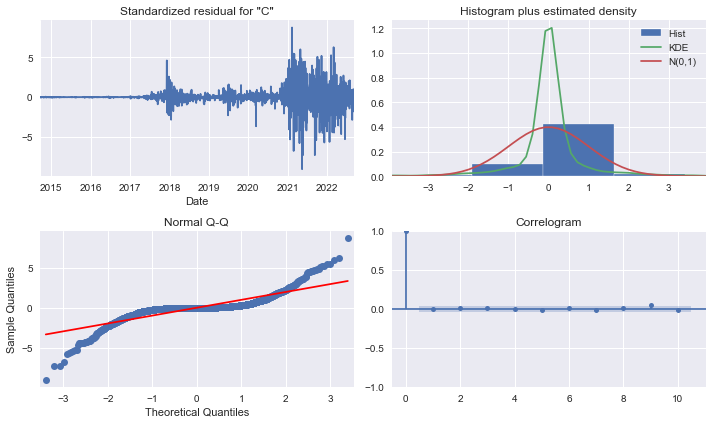

In [13]:
model = SARIMAX(train.Close, order=(4,1,6))
model_fit = model.fit(disp=False)
# Residual analysis
model_fit.plot_diagnostics(figsize=(10,6))
plt.tight_layout()
plt.show()

In [14]:
residuals = model_fit.resid

lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
pvalues = list(map(lambda x: round(x,3), lb_df.lb_pvalue.tolist()))
print(pvalues)

[0.847, 0.941, 0.968, 0.992, 0.978, 0.989, 0.978, 0.983, 0.356, 0.388]


In [15]:
test_list = test.Close.tolist()
train_hist = train.Close.tolist()
pred = []

for obs in tqdm_notebook(test_list):
    model = SARIMAX(train_hist, order=(4,1,6))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast()[0]
    
    pred.append(forecast)
    train_hist.append(obs)
    
test['pred'] = pred
# print(model_fit.summary())

  0%|          | 0/30 [00:00<?, ?it/s]

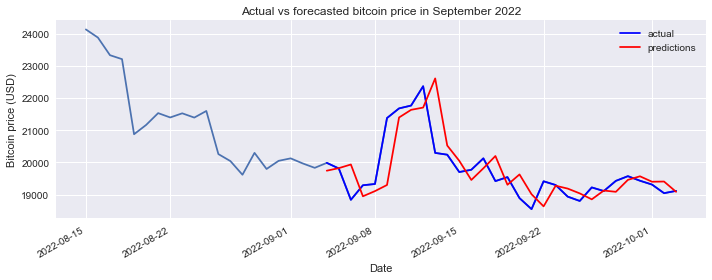

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df.index.tolist()[-50:], df.Close[-50:])
ax.plot(test.Close, 'b-', label='actual')
ax.plot(test['pred'], 'r', label='predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price (USD)')
ax.set_title('Actual vs forecasted bitcoin price in September 2022')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
error = mape(test.Close, test['pred'])
print(f"Error: {error:.2f}")

Error: 2.28


In [29]:
forecasts = []
for i in tqdm_notebook(range(30)):
    model = SARIMAX(train_hist, order=(4,1,6))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast()[0]
    
    forecasts.append(forecast)
    train_hist.append(forecast)

  0%|          | 0/30 [00:00<?, ?it/s]

Plot Forecasted bitcoin prices

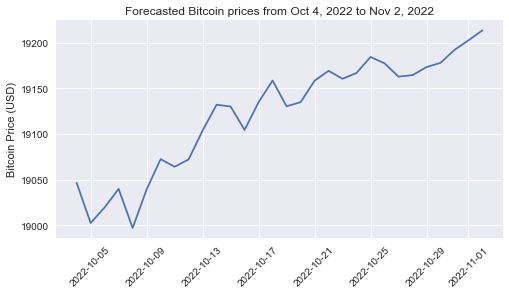

In [53]:
# Generate dates
dates = [datetime.date(2022, 10, 4) + datetime.timedelta(days=x) for x in range(30)]
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(dates, forecasts)
ax.set_title("Forecasted Bitcoin prices from Oct 4, 2022 to Nov 2, 2022")
ax.set_ylabel('Bitcoin Price (USD)')
plt.xticks(rotation=45)
plt.show()